In [596]:
# PATHS TO FILES
# Attempt 1 at basic code assigning a movie/ads spaces to a schedule

import numpy as np
import pandas as pd
import xpress as xp
from datetime import datetime, timedelta
import os

# Define the base path explicitly to where your files are stored
# This is the correct path on your machine
base_path = 'D:/OneDrive/Documents/EDINBURGH/MMCS/final_project/repository/mmcsfinalproject/data'

# Read in files using the explicitly defined base path
ch_0_conversion_rates = pd.read_csv(os.path.join(base_path, 'channel_0_conversion_rates.csv'))
ch_0_schedule = pd.read_csv(os.path.join(base_path, 'channel_0_schedule.csv'))
ch_1_conversion_rates = pd.read_csv(os.path.join(base_path, 'channel_1_conversion_rates.csv'))
ch_1_schedule = pd.read_csv(os.path.join(base_path, 'channel_1_schedule.csv'))
ch_2_conversion_rates = pd.read_csv(os.path.join(base_path, 'channel_2_conversion_rates.csv'))
ch_2_schedule = pd.read_csv(os.path.join(base_path, 'channel_2_schedule.csv'))
ch_A_schedule = pd.read_csv(os.path.join(base_path, 'channel_A_schedule.csv'))
movies_df = pd.read_csv(os.path.join(base_path, 'movie_database.csv'))

In [597]:
# FORMATING
# Convert 'Date-Time' columns to datetime format
date_cols = ['Date']

for df in [ch_0_conversion_rates, ch_0_schedule, ch_1_conversion_rates, ch_1_schedule,
           ch_2_conversion_rates, ch_2_schedule, ch_A_schedule]:
    df['Date'] = pd.to_datetime(df['Date'])

# Convert 'Release Date' in movie_database to datetime
movies_df['release_date'] = pd.to_datetime(movies_df['release_date'])

# Fill missing values if necessary
movies_df.fillna(0, inplace=True)


In [598]:
# Prepare the list of all genres
all_genres = sorted({genre for genres_list in movies_df['genres'].apply(eval) for genre in genres_list})
print(all_genres)

['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western']


In [599]:
# Slot duration 30 minutes
slot_duration = 30  # minutes
movies_df['slots_needed'] = (movies_df['runtime_with_ads'] / slot_duration).apply(lambda x: int(x)).astype(int)


In [600]:
from datetime import datetime, timedelta

num_days = 15

# Define the broadcasting start and end dates
broadcast_start_date = datetime.strptime("2024-10-01", "%Y-%m-%d")
broadcast_end_date = broadcast_start_date + timedelta(days=num_days)  # 7 days including start date

# Define daily broadcast start and end times
daily_broadcast_start_time = timedelta(hours=7, minutes=0)
daily_broadcast_end_time = timedelta(hours=23, minutes=55)

# Slot durations
slot_duration_30min = 30  # 30 minutes
slot_duration_5min = 5  # 5 minutes

# Generate all time slots over the date range
time_slots = []  # For 30-minute intervals
time_slots_5min = []  # For 5-minute intervals
current_date = broadcast_start_date

while current_date <= broadcast_end_date:
    # Set the start and end times for the current day
    day_start = datetime.combine(current_date.date(), datetime.min.time()) + daily_broadcast_start_time
    day_end = datetime.combine(current_date.date(), datetime.min.time()) + daily_broadcast_end_time

    current_time = day_start
    while current_time <= day_end:
        # Add to 30-minute slots
        if (current_time - day_start).seconds % (slot_duration_30min * 60) == 0:
            time_slots.append(current_time)
        # Add to 5-minute slots
        time_slots_5min.append(current_time)

        current_time += timedelta(minutes=slot_duration_5min)
    
    # Move to the next day
    current_date += timedelta(days=1)

# Create mappings between time slots and indices
time_to_index_30min = {t: idx for idx, t in enumerate(time_slots)}
index_to_time_30min = {idx: t for idx, t in enumerate(time_slots)}

time_to_index_5min = {t: idx for idx, t in enumerate(time_slots_5min)}
index_to_time_5min = {idx: t for idx, t in enumerate(time_slots_5min)}

# Print the first few slots as a sanity check
print("First few 30-minute time slots:")
print(time_slots[-5:])

print("\nFirst few 5-minute time slots:")
print(time_slots_5min[-5:])



First few 30-minute time slots:
[datetime.datetime(2024, 10, 16, 21, 30), datetime.datetime(2024, 10, 16, 22, 0), datetime.datetime(2024, 10, 16, 22, 30), datetime.datetime(2024, 10, 16, 23, 0), datetime.datetime(2024, 10, 16, 23, 30)]

First few 5-minute time slots:
[datetime.datetime(2024, 10, 16, 23, 35), datetime.datetime(2024, 10, 16, 23, 40), datetime.datetime(2024, 10, 16, 23, 45), datetime.datetime(2024, 10, 16, 23, 50), datetime.datetime(2024, 10, 16, 23, 55)]


In [601]:
from datetime import time
# Set 'Date' as index
ch_A_schedule.set_index('Date', inplace=True)

# Resample to 30-minute intervals (use mean of groups)
ch_A_schedule_30min = ch_A_schedule.resample('30T').mean().reset_index()

# Define start and end times for filtering
daily_start_time = time(7, 0)  # 7:00 AM
daily_end_time = time(23, 55)  # 11:55 PM

# Filter rows to include only time slots within the desired range 
ch_A_schedule_30min['time'] = ch_A_schedule_30min['Date'].dt.time
ch_A_schedule_30min = ch_A_schedule_30min[
    (ch_A_schedule_30min['time'] >= daily_start_time) &
    (ch_A_schedule_30min['time'] <= daily_end_time)
].drop(columns=['time'])

# Print the first 5 rows
print("First 5 rows of ch_A_schedule_30min:")
print(ch_A_schedule_30min.head(3))



First 5 rows of ch_A_schedule_30min:
                 Date  children_baseline_view_count  \
0 2024-10-01 07:00:00                      0.019383   
1 2024-10-01 07:30:00                      0.015485   
2 2024-10-01 08:00:00                      0.009684   

   adults_baseline_view_count  retirees_baseline_view_count  prime_time_factor  
0                    0.022296                      0.003611                1.0  
1                    0.022928                      0.004694                1.0  
2                    0.024245                      0.006021                1.0  


C:\Users\antor\AppData\Local\Temp\ipykernel_7500\762425869.py:6: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  ch_A_schedule_30min = ch_A_schedule.resample('30T').mean().reset_index()


In [602]:
# Resample competitor channels to 30-minute intervals and filter time slots
competitor_schedules = {}
competitor_channel_ids = [0, 1, 2]  # Assuming channels 0, 1, and 2 are competitors

for i, ch_schedule in zip(competitor_channel_ids, [ch_0_schedule, ch_1_schedule, ch_2_schedule]):
    # Set 'Date' as index
    ch_schedule.set_index('Date', inplace=True)
    
    # Separate numeric and non-numeric columns
    numeric_cols = ch_schedule.select_dtypes(include=[np.number]).columns
    non_numeric_cols = ch_schedule.select_dtypes(exclude=[np.number]).columns
    
    # Resample numeric columns with mean, except for ad_slot_price where max is used
    ch_schedule_numeric = ch_schedule[numeric_cols].resample('30T').agg(
        {'ad_slot_price': 'max', **{col: 'mean' for col in numeric_cols if col != 'ad_slot_price'}}
    )
    
    # Resample non-numeric columns with mode or first
    ch_schedule_non_numeric = ch_schedule[non_numeric_cols].resample('30T').agg(
        lambda x: x.mode()[0] if not x.mode().empty else None
    )
    
    # Combine resampled numeric and non-numeric columns
    ch_schedule_30min = pd.concat([ch_schedule_numeric, ch_schedule_non_numeric], axis=1).reset_index()
    
    # Extract time component
    ch_schedule_30min['time'] = ch_schedule_30min['Date'].dt.time
    
    # Filter rows to include only time slots within the desired range 
    ch_schedule_30min = ch_schedule_30min[
        (ch_schedule_30min['time'] >= daily_start_time) &
        (ch_schedule_30min['time'] <= daily_end_time)
    ].drop(columns=['time'])
    
    # Store in competitor_schedules dictionary
    competitor_schedules[i] = ch_schedule_30min
    
    # Print the first few rows to verify
    # print(f"First 5 rows of competitor channel {i} schedule:")
    # print(ch_schedule_30min.head(1))


C:\Users\antor\AppData\Local\Temp\ipykernel_7500\382912201.py:14: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  ch_schedule_numeric = ch_schedule[numeric_cols].resample('30T').agg(
C:\Users\antor\AppData\Local\Temp\ipykernel_7500\382912201.py:19: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  ch_schedule_non_numeric = ch_schedule[non_numeric_cols].resample('30T').agg(
C:\Users\antor\AppData\Local\Temp\ipykernel_7500\382912201.py:14: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  ch_schedule_numeric = ch_schedule[numeric_cols].resample('30T').agg(
C:\Users\antor\AppData\Local\Temp\ipykernel_7500\382912201.py:19: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  ch_schedule_non_numeric = ch_schedule[non_numeric_cols].resample('30T').agg(
C:\Users\antor\AppData\Local\Temp\ip

In [603]:
competitor_schedules[1].head()


,Date,ad_slot_price,movie_popularity_factor,children_popularity_factor,adults_popularity_factor,retirees_popularity_factor,movie_budget,box_office_revenue,n_ad_breaks,prime_time_factor,...,retirees_true_view_count_2,retirees_true_view_count_3,retirees_true_view_count_4,retirees_true_view_count_5,retirees_true_view_count_6,retirees_true_view_count_7,retirees_true_view_count_8,retirees_true_view_count_9,content,content_type
0,2024-10-01 07:00:00,25458.66,0.448213,0.179285,0.448213,0.448213,1.500000e+07,4.486219e+07,4.0,1.0,...,0.003259,0.002893,0.003714,0.002328,0.003757,0.002953,0.002011,0.003763,Cop Land,Movie
1,2024-10-01 07:30:00,25458.66,0.328636,0.203147,0.328636,0.328636,9.666667e+06,3.590762e+07,4.0,1.0,...,0.002848,0.002192,0.003080,0.002872,0.001943,0.001546,0.001288,0.003119,A Serious Man,Movie
2,2024-10-01 08:00:00,16629.10,0.268847,0.215078,0.268847,0.268847,7.000000e+06,3.143033e+07,4.0,1.0,...,0.002734,0.001299,0.001097,0.002022,0.003903,0.002596,0.002034,0.004616,A Serious Man,Movie
3,2024-10-01 08:30:00,16629.10,0.268847,0.215078,0.268847,0.268847,7.000000e+06,3.143033e+07,4.0,1.0,...,0.003719,0.003104,0.004183,0.002901,0.004074,0.002724,0.002746,0.004551,A Serious Man,Movie
4,2024-10-01 09:00:00,16629.10,0.268847,0.215078,0.268847,0.268847,7.000000e+06,3.143033e+07,4.0,1.0,...,0.004387,0.002626,0.003270,0.002544,0.003398,0.002801,0.001727,0.007070,A Serious Man,Movie


In [604]:
(np.divide(competitor_schedules[1]['ad_slot_price'].sum(),
(competitor_schedules[1]['children_expected_view_count'].sum() + 
competitor_schedules[1]['adults_expected_view_count'].sum() + 
competitor_schedules[1]['retirees_expected_view_count'].sum()))) /1000000

0.8711850159710204

In [605]:
for i in range(3):
    competitor_schedules[i][f'competitor_audience_ch{i}'] = (competitor_schedules[i]['children_expected_view_count'] 
                                                        +competitor_schedules[i]['adults_expected_view_count']
                                                        +competitor_schedules[i]['retirees_expected_view_count'])* 1000000 * competitor_schedules[1]['prime_time_factor']
competitor_schedules[2]




,Date,ad_slot_price,movie_popularity_factor,children_popularity_factor,adults_popularity_factor,retirees_popularity_factor,movie_budget,box_office_revenue,n_ad_breaks,prime_time_factor,...,retirees_true_view_count_3,retirees_true_view_count_4,retirees_true_view_count_5,retirees_true_view_count_6,retirees_true_view_count_7,retirees_true_view_count_8,retirees_true_view_count_9,content,content_type,competitor_audience_ch2
0,2024-10-01 07:00:00,365283.35,1.000000,0.800000,0.800000,0.800000,1.750000e+08,8.576112e+08,4.0,1.000000,...,0.004134,0.005371,0.002040,0.005111,0.005483,0.005856,0.003383,Inside Out,Movie,63406.425543
1,2024-10-01 07:30:00,365283.35,1.000000,0.800000,0.800000,0.800000,1.750000e+08,8.576112e+08,4.0,1.000000,...,0.006740,0.007672,0.004885,0.003606,0.007912,0.008774,0.002754,Inside Out,Movie,60349.886384
2,2024-10-01 08:00:00,365283.35,1.000000,0.800000,0.800000,0.800000,1.750000e+08,8.576112e+08,4.0,1.000000,...,0.008516,0.007022,0.004404,0.007227,0.009651,0.011044,0.006240,Inside Out,Movie,55929.933883
3,2024-10-01 08:30:00,365283.35,0.658089,0.461520,0.591423,0.526471,5.966667e+07,3.158704e+08,4.0,1.000000,...,0.006988,0.006922,0.006624,0.004658,0.007091,0.006941,0.004570,Death Wish II,Movie,38127.858850
4,2024-10-01 09:00:00,17700.00,0.487134,0.292280,0.487134,0.389707,2.000000e+06,4.500000e+07,4.0,1.000000,...,0.006244,0.006944,0.005204,0.006657,0.007530,0.006468,0.003149,Death Wish II,Movie,32030.947977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4013,2024-12-23 21:30:00,50364.70,0.377401,0.226441,0.377401,0.276324,2.726667e+07,2.833395e+07,4.0,1.500000,...,0.010028,0.005010,0.008777,0.006480,0.008066,0.007592,0.005496,See How They Run,Movie,117076.467944
4014,2024-12-23 22:00:00,16427.63,0.383943,0.230366,0.383943,0.230366,1.800000e+06,4.115876e+07,4.0,1.083333,...,0.004969,0.004710,0.003814,0.004964,0.004604,0.004011,0.004638,The French Connection,Movie,79456.058158
4015,2024-12-23 22:30:00,16427.63,0.383943,0.230366,0.383943,0.230366,1.800000e+06,4.115876e+07,4.0,1.000000,...,0.003895,0.003597,0.004995,0.003018,0.004365,0.003256,0.004124,The French Connection,Movie,68494.077914
4016,2024-12-23 23:00:00,16427.63,0.383943,0.230366,0.383943,0.230366,1.800000e+06,4.115876e+07,4.0,1.000000,...,0.002825,0.002676,0.004115,0.003593,0.007569,0.003707,0.001271,The French Connection,Movie,63576.101793


In [606]:
# Assuming competitor_schedules is a dictionary of DataFrames for channels 0, 1, and 2

# Create competitor_audience for all channels
competitor_audience = {}

for i in range(3):  # Loop through competitor channels
    # Add competitor audience to the DataFrame and store it in the dictionary
    competitor_schedules[i][f'competitor_audience_ch{i}'] = (
        competitor_schedules[i]['children_expected_view_count']
        + competitor_schedules[i]['adults_expected_view_count']
        + competitor_schedules[i]['retirees_expected_view_count']
    ) * 1_000_000 * competitor_schedules[i]['prime_time_factor']
    
    # Create a mapping of time slot to audience for the channel
    competitor_audience[i] = dict(zip(
        competitor_schedules[i].index,
        competitor_schedules[i][f'competitor_audience_ch{i}']
    ))

# Example: Check the resulting competitor_audience for channel 2
competitor_audience[1]


{0: 22630.687866547334,
 1: 18239.728313212985,
 2: 15329.594667065683,
 3: 15181.079508663634,
 4: 16064.517827501464,
 5: 28796.94815927193,
 6: 44280.29123356291,
 7: 50313.66872950966,
 8: 57067.70229943678,
 9: 61462.88593531277,
 10: 62815.08369040605,
 11: 70334.16775069815,
 12: 78272.86291285884,
 13: 78780.79887483096,
 14: 45877.563712749965,
 15: 49920.57071514356,
 16: 53766.238489965566,
 17: 57213.552752515374,
 18: 166713.4277907814,
 19: 173683.24169016074,
 20: 177156.34601717745,
 21: 177029.04675226987,
 22: 274225.98069699673,
 23: 264443.19353146927,
 24: 248970.22659411933,
 25: 210944.61214156746,
 26: 191122.51468325945,
 27: 182863.30629957048,
 28: 121734.20164259177,
 29: 63747.29133171789,
 30: 42807.35442061906,
 31: 36604.60328571978,
 32: 50816.481115085386,
 33: 79311.64656951766,
 48: 23175.091897054466,
 49: 22389.62190202605,
 50: 21272.144294858666,
 51: 21066.0567738827,
 52: 22291.961709315117,
 53: 39636.292015738574,
 54: 52485.08701562416,
 55:

In [607]:
viewer_revenue_dic = {}
for i in range(3):
    viewer_revenue_dic[i] = (np.divide(competitor_schedules[i]['ad_slot_price'].sum(),
    (competitor_schedules[i]['children_expected_view_count'].sum() + 
    competitor_schedules[i]['adults_expected_view_count'].sum() + 
    competitor_schedules[i]['retirees_expected_view_count'].sum()))) /1000000

viewer_revenue = sum(viewer_revenue_dic.values()) / len(viewer_revenue_dic.values())
viewer_revenue

1.1080151271934982

In [608]:
# Check for duplicate movie titles
duplicate_titles = movies_df[movies_df.duplicated(subset=['title'], keep=False)]
if not duplicate_titles.empty:
    print("Duplicate movie titles found:")
    print(duplicate_titles['title'])
else:
    print("No duplicate movie titles found.")


Duplicate movie titles found:
4                 The Avengers
17                     Titanic
76               The Lion King
105       Beauty and the Beast
149        Alice in Wonderland
                 ...          
5748              Midnight Sun
5761                The Island
5773            The Shaggy Dog
5855    Fun with Dick and Jane
5879        The Perfect Weapon
Name: title, Length: 258, dtype: object


In [609]:
print(movies_df.head(1))

       title  vote_average  vote_count release_date    revenue  runtime  \
0  Inception         8.364       34495   2010-07-15  825532764      148   

      budget  popularity                                      genres  \
0  160000000      83.952  ['Action', 'Science Fiction', 'Adventure']   

   n_ad_breaks  runtime_with_ads  scaled_popularity  \
0            5             180.0           0.972027   

   children_scaled_popularity  adults_scaled_popularity  \
0                    0.777622                  0.972027   

   retirees_scaled_popularity  slots_needed  
0                    0.388811             6  


In [610]:
def get_views(m, t_idx, movies, our_channel):
    # Baseline viewership at time slot t_idx
    baseline = {
        'children': our_channel.iloc[t_idx]['children_baseline_view_count'],
        'adults': our_channel.iloc[t_idx]['adults_baseline_view_count'],
        'retirees': our_channel.iloc[t_idx]['retirees_baseline_view_count']
    }
    
    # Scaled popularity of movie m
    popularity = {
        'children': movies.loc[m, 'children_scaled_popularity'],
        'adults': movies.loc[m, 'adults_scaled_popularity'],
        'retirees': movies.loc[m, 'retirees_scaled_popularity']
    }
    
    # Calculate baseline viewership
    total_population = 1_000_000
    baseline_viewership = sum(
        baseline[demo] * popularity[demo] * total_population
        for demo in ['children', 'adults', 'retirees']
    )
    
    return baseline_viewership


In [611]:
def compute_additional_viewers(m, t_idx, movies, competitor_schedules, competitor_viewerships, conversion_rates):
    additional_viewers = 0
    # Loop over competitor channels
    for ch_id, ch_schedule in competitor_schedules.items():
        # Check if we are advertising on this channel at this time slot
        # For simplicity, assume we have a decision variable a_comp[m, ch_id, t_idx]
        # In data preparation, we'll precompute the potential additional viewers
        
        # Example (this needs to be integrated with your model variables):
        # if a_comp[m, ch_id, t_idx] > 0.5:
        #     # Get the conversion rate
        #     conversion_rate = conversion_rates.get((m, ch_id, t_idx), 0)
        #     # Get the baseline audience size for the competitor channel at this time slot
        #     competitor_audience = competitor_viewerships[ch_id].iloc[t_idx]['baseline_view_count']
        #     # Calculate additional viewers
        #     additional_viewers += conversion_rate * competitor_audience
    
        return additional_viewers


In [612]:
def model(T, movies, our_channel, time_slots):
    prob = xp.problem(name="Movie_Scheduling_Problem")
    

    # Constants
    slots_per_day = 34  # Number of slots per day (e.g., from 07:00 to 23:30)
    days = len(time_slots) // slots_per_day  # Number of days in the schedule
    M = len(time_slots)  # Big M for constraints
    T_end = len(time_slots) - 1  # Last time slot index

    
    # Decision Variables
    x = {(m, t): xp.var(vartype=xp.binary, name='x_{0}_{1}'.format(m, t)) 
         for m in movies.index for t in T}
    prob.addVariable(list(x.values()))
    
    y = {m: xp.var(vartype=xp.binary, name='y_{0}'.format(m)) for m in movies.index}
    prob.addVariable(list(y.values()))
    
    s = {m: xp.var(vartype=xp.integer, name='s_{0}'.format(m)) for m in movies.index}
    e = {m: xp.var(vartype=xp.integer, name='e_{0}'.format(m)) for m in movies.index}
    prob.addVariable(list(s.values()))
    prob.addVariable(list(e.values()))
    
    u = {(m, t): xp.var(vartype=xp.continuous, name='u_{0}_{1}'.format(m, t)) 
         for m in movies.index for t in T}
    prob.addVariable(list(u.values()))

    # # Integer variable D[m]: day on which movie m starts
    # D = {m: xp.var(vartype=xp.integer, lb=0, ub=days - 1, name='D_{0}'.format(m)) for m in movies.index}
    # prob.addVariable(list(D.values()))

    # VARIABLES FOR ADVERTISING
    # Binary variable a_own[m, t]: 1 if we advertise movie m on our channel at time slot t
    a_own = {(m, t): xp.var(vartype=xp.binary, name='a_own_{0}_{1}'.format(m, t))
            for m in movies.index for t in T}
    prob.addVariable(list(a_own.values()))

    # Binary variable a_comp[m, c, t]: 1 if we advertise movie m on competitor channel c at time slot t
    # For simplicity, assume c ranges over competitor channel IDs
    competitor_channel_ids = [0, 1, 2]
    a_comp = {(m, c, t): xp.var(vartype=xp.binary, name='a_comp_{0}_{1}_{2}'.format(m, c, t))
            for m in movies.index for c in competitor_channel_ids for t in T}
    prob.addVariable(list(a_comp.values()))

    
    decision_vars = [x, y, s, e, u, a_own, a_comp]
    
    # Constraints
    
    # 1. Movie Duration Constraint
    for m in movies.index:
        prob.addConstraint(
            xp.Sum(x[m, t] for t in T) == movies.loc[m, 'slots_needed'] * y[m]
        )
    
    # 2. Time Slot Occupancy Constraint
    for t in T:
        prob.addConstraint(
            xp.Sum(x[m, t] for m in movies.index) == 1
        )
    
    # 3. Start Time Constraints
    for m in movies.index:
        for t in T:
            prob.addConstraint(
                s[m] <= t * x[m, t] + (1 - x[m, t]) * M
            )
    
    # 4. End Time Constraints
    for m in movies.index:
        for t in T:
            prob.addConstraint(
                e[m] >= (t + 1) * x[m, t]
            )
    
    # 5. Movie Duration Relationship Constraint
    for m in movies.index:
        prob.addConstraint(
            e[m] - s[m] == movies.loc[m, 'slots_needed'] * y[m]
        )
    
    # 6. Latest Start Time Constraint
    for m in movies.index:
        prob.addConstraint(
            s[m] + movies.loc[m, 'slots_needed'] - 1 <= T_end
        )
    

    # 7. View Count Constraints
    for m in movies.index:
        for t_idx, t in enumerate(T):
            baseline_viewership = get_views(m, t_idx, movies, our_channel)
            prob.addConstraint(
                u[m, t] == baseline_viewership * x[m, t]
            )

    #8 Movie Budget Constraint
    

    # 9. Objective Function
    prob.setObjective(
        xp.Sum(u[m, t] for m in movies.index for t in T),
        sense=xp.maximize
    )
    
    return prob, decision_vars


In [613]:
movies_df.head(1)

,title,vote_average,vote_count,release_date,revenue,runtime,budget,popularity,genres,n_ad_breaks,runtime_with_ads,scaled_popularity,children_scaled_popularity,adults_scaled_popularity,retirees_scaled_popularity,slots_needed
0,Inception,8.364,34495,2010-07-15,825532764,148,160000000,83.952,"['Action', 'Science Fiction', 'Adventure']",5,180.0,0.972027,0.777622,0.972027,0.388811,6


In [614]:
# import license_fee
# # Merge ch_A_schedule_30min with movies_df on the movie title as identifier
# ch_A_schedule_30min = pd.merge(
#     ch_A_schedule_30min,
#     movies_df[['title', 'budget', 'revenue', 'n_ad_breaks']],
#     left_on='content',  # Adjust 'content' to the column in `ch_A_schedule_30min` that holds the movie title
#     right_on='title',
#     how='left'
# )

# # Rename columns to match the function's expectation
# ch_A_schedule_30min.rename(
#     columns={
#         'budget': 'movie_budget',
#         'revenue': 'box_office_revenue'
#     },
#     inplace=True
# )

# # Set default prime time factor if not already present
# if 'prime_time_factor' not in ch_A_schedule_30min.columns:
#     ch_A_schedule_30min['prime_time_factor'] = 1.0  # Adjust as needed

import license_fee

# Calculate ad slot prices
base_fee = 10_000
profit_margin = 0.2
budget_factor = 0.002
box_office_factor = 0.001


movies_df['ad_slot_cost'] = license_fee.calculate_ad_slot_price_movie_df(
    schedule_df=movies_df,
    base_fee=base_fee,
    profit_margin=profit_margin,
    budget_factor=budget_factor,
    box_office_factor=box_office_factor
) 

# Print result for validation
print(movies_df[['title', 'ad_slot_cost']].head(34))




                                                title  ad_slot_cost
0                                           Inception     277327.86
1                                        Interstellar     208345.84
2                                     The Dark Knight     276911.69
3                                              Avatar     681541.21
4                                        The Avengers     472515.72
5                                            Deadpool     272730.00
6                              Avengers: Infinity War     638979.61
7                                          Fight Club      56844.90
8                             Guardians of the Galaxy     269466.38
9                                        Pulp Fiction      48180.00
10                                       Forrest Gump     191373.05
11           Harry Potter and the Philosopher's Stone     247295.11
12                                           Iron Man     210041.81
13                                   Django Unch

In [615]:
movies_df['estimated_cost_x_viewer'] = movies_df['ad_slot_cost'] / (
    ((movies_df['children_scaled_popularity'] * 0.0079 +
     movies_df['adults_scaled_popularity'] * 0.0661 +
     movies_df['retirees_scaled_popularity'] * 0.0207) * 1000000)
)
movies_df

,title,vote_average,vote_count,release_date,revenue,runtime,budget,popularity,genres,n_ad_breaks,runtime_with_ads,scaled_popularity,children_scaled_popularity,adults_scaled_popularity,retirees_scaled_popularity,slots_needed,ad_slot_cost,estimated_cost_x_viewer
0,Inception,8.364,34495,2010-07-15,825532764,148,160000000,83.952,"['Action', 'Science Fiction', 'Adventure']",5,180.0,0.972027,7.776220e-01,0.972027,3.888110e-01,6,277327.86,3.535424
1,Interstellar,8.417,32571,2014-11-05,701729206,169,165000000,140.241,"['Adventure', 'Drama', 'Science Fiction']",6,210.0,1.000000,6.000000e-01,1.000000,6.000000e-01,7,208345.84,2.502352
2,The Dark Knight,8.512,30619,2008-07-16,1004558444,152,185000000,130.643,"['Drama', 'Action', 'Crime', 'Thriller']",6,180.0,1.000000,6.000000e-01,1.000000,8.000000e-01,6,276911.69,3.168326
3,Avatar,7.573,29815,2009-12-15,2923706026,162,237000000,79.932,"['Action', 'Adventure', 'Fantasy', 'Science Fi...",6,180.0,0.958199,7.665595e-01,0.958199,3.832798e-01,6,681541.21,8.813790
4,The Avengers,7.710,29166,2012-04-25,1518815515,143,220000000,98.082,"['Science Fiction', 'Action', 'Adventure']",5,180.0,1.000000,8.000000e-01,1.000000,4.000000e-01,6,472515.72,5.855213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5915,The In Crowd,4.480,51,2000-07-19,5217498,105,15000000,7.687,"['Drama', 'Mystery', 'Thriller']",4,120.0,0.072803,2.912130e-02,0.072803,5.824260e-02,4,13565.25,2.171142
5916,Mr. Saturday Night,5.769,51,1992-09-23,13300000,119,43000000,6.498,"['Comedy', 'Drama']",4,150.0,0.000001,8.000000e-07,0.000001,1.000000e-06,5,32790.00,352126.288660
5917,Young Doctors in Love,5.204,51,1982-07-16,30688860,96,7500000,6.055,['Comedy'],4,120.0,0.000001,1.000000e-06,0.000001,1.000000e-06,4,16706.66,176416.684266
5918,End of the Spear,6.010,51,2005-10-24,12128105,108,10000000,6.506,"['Adventure', 'Drama', 'History']",4,120.0,0.000001,6.000000e-07,0.000001,8.000000e-07,4,12638.43,144604.462243


In [616]:
remaining_movies = movies_df.nsmallest(1000, 'estimated_cost_x_viewer').reset_index(drop=True)
remaining_movies

,title,vote_average,vote_count,release_date,revenue,runtime,budget,popularity,genres,n_ad_breaks,runtime_with_ads,scaled_popularity,children_scaled_popularity,adults_scaled_popularity,retirees_scaled_popularity,slots_needed,ad_slot_cost,estimated_cost_x_viewer
0,Skinamarink,5.700,148,2023-01-13,2100000,100,15000,75.178,"['Horror', 'Mystery']",4,120.0,0.940721,0.376289,0.940721,0.752577,4,3639.00,0.045075
1,The Day the Earth Stood Still,7.472,989,1951-09-28,1850000,92,995000,46.696,"['Drama', 'Science Fiction', 'Thriller']",4,120.0,0.796901,0.318760,0.796901,0.478140,4,4152.00,0.063788
2,Monty Python and the Holy Grail,7.797,5280,1975-05-25,1940906,91,400000,28.015,"['Adventure', 'Comedy', 'Fantasy']",4,120.0,0.624338,0.624338,0.624338,0.374603,4,3822.27,0.070841
3,Reservoir Dogs,8.132,13296,1992-09-02,2859750,99,1200000,34.018,"['Crime', 'Thriller']",4,120.0,0.692375,0.276950,0.692375,0.553900,4,4577.92,0.077044
4,Winnie the Pooh: Blood and Honey,5.492,835,2023-01-27,5200000,84,100000,96.154,"['Horror', 'Thriller']",3,90.0,1.000000,0.400000,1.000000,0.400000,3,6160.00,0.079443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Dark Waters,7.530,1860,2019-11-22,13601384,127,20000000,18.382,"['Drama', 'Thriller']",5,150.0,0.464925,0.185970,0.464925,0.371940,5,15264.33,0.382566
996,Filth,6.860,1562,2013-09-23,9114264,97,5000000,11.088,"['Crime', 'Drama', 'Comedy']",4,120.0,0.249048,0.149429,0.249048,0.249048,4,8734.28,0.383119
997,Extract,5.806,532,2009-09-03,10848783,92,8000000,12.536,['Comedy'],4,120.0,0.304201,0.304201,0.304201,0.304201,4,11054.63,0.383737
998,"Hello, My Name Is Doris",6.447,447,2015-11-27,14659448,95,1000000,10.583,"['Comedy', 'Drama', 'Romance']",4,120.0,0.227609,0.136565,0.227609,0.227609,4,7997.83,0.383859


In [617]:
n = 14  # Number of iterations
number_of_time_slots = 34  # Number of time slots per subset

# Start with the full movies dataset
remaining_movies = movies_df.nsmallest(300, 'estimated_cost_x_viewer').reset_index(drop=True)

# Initialize a list to store results and decision variables for each iteration
results = []
decision_variables_per_iteration = []  # To store decision variables for all iterations

for i in range(n):
    print(f"Processing iteration {i + 1}")
    
    # Define the subset of time slots for the current iteration
    start_idx = i * number_of_time_slots
    end_idx = start_idx + number_of_time_slots
    time_slots_subset = time_slots[start_idx:end_idx]
    
    # Define T as the range of indices for the current subset of time slots
    T_subset = list(range(len(time_slots_subset)))
    
    # Subset ch_A_schedule_30min to match the current time slots
    ch_A_schedule_30min_subset = ch_A_schedule_30min.iloc[start_idx:end_idx]
    
    # Use the remaining movies for the current iteration
    movies_subset = remaining_movies.copy()
    
    # If there are no movies left, break the loop
    if movies_subset.empty:
        print("No movies left to schedule.")
        break
    
    # Call the model function with the subsets
    prob, decision_vars = model(T_subset, movies_subset, ch_A_schedule_30min_subset, time_slots_subset)
    
    # Solve the problem
    prob.solve()
    
    # Retrieve the solver status
    status = prob.getProbStatus()
    print(f"Solver Status for iteration {i + 1}: {status}")
    
    if status in [1, 6]:  # Optimal or feasible solution
        # Store decision variables for this iteration
        decision_variables_per_iteration.append({
            "iteration": i + 1,
            "decision_vars": decision_vars,
            "prob": prob,
            "T_subset": T_subset,
            "time_slots_subset": time_slots_subset,
            "movies_subset": movies_subset
        })
    
    # Retrieve scheduled movies
    x, y, s, e, u, a_own, a_comp = decision_vars  # Unpack decision variables
    scheduled_movies = [
        m for m in movies_subset.index 
        if any(prob.getSolution(x[m, t]) > 0.5 for t in T_subset)
    ]
    
    # Remove scheduled movies from remaining_movies
    remaining_movies = remaining_movies.drop(index=scheduled_movies).reset_index(drop=True)
    
    # Store results
    results.append({
        "iteration": i + 1,
        "status": status,
        "objective_value": prob.getObjVal() if status in [1, 6] else None,
        "scheduled_movies": [movies_subset.loc[m_idx, 'title'] for m_idx in scheduled_movies]
    })

# Combine all results into a single DataFrame for easier analysis
results_df = pd.DataFrame(results)

# Display the results
print("Results of all iterations:")
print(results_df)

# Generate schedule_df using the stored decision variables
all_schedules = []

for iteration_data in decision_variables_per_iteration:
    iteration = iteration_data["iteration"]
    decision_vars = iteration_data["decision_vars"]
    prob = iteration_data["prob"]
    T_subset = iteration_data["T_subset"]
    time_slots_subset = iteration_data["time_slots_subset"]
    movies_subset = iteration_data["movies_subset"]

    x, y, s, e, u, a_own, a_comp = decision_vars  # Unpack decision variables

    for t in range(len(time_slots_subset)):
        for m_idx, m_row in movies_subset.iterrows():
            x_value = prob.getSolution(x[m_idx, t])
            if x_value > 0.5:  # If movie is scheduled at this time slot
                # Extract movie details
                movie_title = m_row['title']
                time_slot = time_slots_subset[t]
                day = time_slot.strftime('%Y-%m-%d')
                time_formatted = time_slot.strftime('%H:%M')

                # Append the details to the schedule
                all_schedules.append({
                    'Iteration': iteration,
                    'Time Slot': t,
                    'Date': day,
                    'Time': time_formatted,
                    'Movie Index': m_idx,
                    'Movie Title': movie_title,
                    'Content': movie_title
                })

# Convert all schedules into a single DataFrame
schedule_df = pd.DataFrame(all_schedules)
schedule_df.sort_values(by=['Iteration', 'Date', 'Time Slot'], inplace=True)
schedule_df.reset_index(drop=True, inplace=True)

# Print the combined schedule
print(schedule_df.head(10))


Processing iteration 1
FICO Xpress v9.4.2, Hyper, solve started 2:50:49, Nov 26, 2024
Heap usage: 24MB (peak 24MB, 13MB system)
Maximizing MILP Movie_Scheduling_Problem using up to 8 threads and up to 11GB memory, with these control settings:
OUTPUTLOG = 1
NLPPOSTSOLVE = 1
XSLP_DELETIONCONTROL = 0
XSLP_OBJSENSE = -1
Original problem has:
     31534 rows        62100 cols        83100 elements     51900 entities
Presolved problem has:
     19759 rows        11100 cols        59850 elements     11100 entities
LP relaxation tightened
Presolve finished in 0 seconds
Heap usage: 35MB (peak 58MB, 13MB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e+00,  1.84e+05] / [ 3.13e-02,  1.94e+00]
  RHS and bounds [min,max] : [ 1.00e+00,  3.40e+01] / [ 1.00e+00,  3.40e+01]
  Objective      [min,max] : [ 1.00e+00,  1.00e+00] / [ 7.29e+03,  1.84e+05]
Autoscaling applied standard scaling

Symmetric problem: generators: 2, support s

In [618]:
schedule_df

,Iteration,Time Slot,Date,Time,Movie Index,Movie Title,Content
0,1,0,2024-10-01,07:00,100,The Blackening,The Blackening
1,1,1,2024-10-01,07:30,100,The Blackening,The Blackening
2,1,2,2024-10-01,08:00,100,The Blackening,The Blackening
3,1,3,2024-10-01,08:30,100,The Blackening,The Blackening
4,1,4,2024-10-01,09:00,0,Skinamarink,Skinamarink
...,...,...,...,...,...,...,...
471,14,29,2024-10-14,21:30,1,The Ritual,The Ritual
472,14,30,2024-10-14,22:00,1,The Ritual,The Ritual
473,14,31,2024-10-14,22:30,165,Sleepaway Camp,Sleepaway Camp
474,14,32,2024-10-14,23:00,165,Sleepaway Camp,Sleepaway Camp


In [621]:
# Adjust Time Slot column to increment continuously across iterations
schedule_df['Time Slot'] += (schedule_df['Iteration'] - 1) * number_of_time_slots

# Sort again by Time Slot to ensure chronological order
schedule_df.sort_values(by=['Time Slot'], inplace=True)
schedule_df.reset_index(drop=True, inplace=True)

# Print the updated DataFrame
schedule_df.head(68)


,Iteration,Time Slot,Date,Time,Movie Index,Movie Title,Content
0,1,0,2024-10-01,07:00,100,The Blackening,The Blackening
1,1,1,2024-10-01,07:30,100,The Blackening,The Blackening
2,1,2,2024-10-01,08:00,100,The Blackening,The Blackening
3,1,3,2024-10-01,08:30,100,The Blackening,The Blackening
4,1,4,2024-10-01,09:00,0,Skinamarink,Skinamarink
...,...,...,...,...,...,...,...
63,2,63,2024-10-02,21:30,4,Terrifier 2,Terrifier 2
64,2,64,2024-10-02,22:00,4,Terrifier 2,Terrifier 2
65,2,65,2024-10-02,22:30,4,Terrifier 2,Terrifier 2
66,2,66,2024-10-02,23:00,4,Terrifier 2,Terrifier 2


In [622]:
ch_A_schedule_30min

,Date,children_baseline_view_count,adults_baseline_view_count,retirees_baseline_view_count,prime_time_factor
0,2024-10-01 07:00:00,0.019383,0.022296,0.003611,1.000000
1,2024-10-01 07:30:00,0.015485,0.022928,0.004694,1.000000
2,2024-10-01 08:00:00,0.009684,0.024245,0.006021,1.000000
3,2024-10-01 08:30:00,0.004744,0.026238,0.007612,1.000000
4,2024-10-01 09:00:00,0.001831,0.028892,0.009478,1.000000
...,...,...,...,...,...
4013,2024-12-23 21:30:00,0.002026,0.106340,0.014459,1.500000
4014,2024-12-23 22:00:00,0.001094,0.101299,0.012007,1.083333
4015,2024-12-23 22:30:00,0.000555,0.095718,0.009817,1.000000
4016,2024-12-23 23:00:00,0.000264,0.089721,0.007904,1.000000


In [623]:
# Ensure the 'Date' in schedule_df is proper datetime objects
schedule_df['DateTime'] = pd.to_datetime(schedule_df['Date'] + ' ' + schedule_df['Time'])

# Create a 'content' column in ch_A_schedule_30min only if it does not exist
if 'content' not in ch_A_schedule_30min.columns:
    ch_A_schedule_30min['content'] = None

# Map scheduled movies to their respective time slots in ch_A_schedule_30min
for _, row in schedule_df.iterrows():
    # Get the specific time slot for the movie
    current_time_slot = row['DateTime']
    
    # Ensure the time slot exists in ch_A_schedule_30min
    if current_time_slot in ch_A_schedule_30min['Date'].values:
        # Update the 'content' column with the movie title
        ch_A_schedule_30min.loc[ch_A_schedule_30min['Date'] == current_time_slot, 'content'] = row['Movie Title']

# Fill remaining rows with 'Advert' only where the 'content' column is still empty
ch_A_schedule_30min['content'] = ch_A_schedule_30min['content'].fillna('Advert')

# Print the first few rows to validate
print(ch_A_schedule_30min[['Date', 'content']].head(68))


                  Date         content
0  2024-10-01 07:00:00  The Blackening
1  2024-10-01 07:30:00  The Blackening
2  2024-10-01 08:00:00  The Blackening
3  2024-10-01 08:30:00  The Blackening
4  2024-10-01 09:00:00     Skinamarink
..                 ...             ...
77 2024-10-02 21:30:00     Terrifier 2
78 2024-10-02 22:00:00     Terrifier 2
79 2024-10-02 22:30:00     Terrifier 2
80 2024-10-02 23:00:00     Terrifier 2
81 2024-10-02 23:30:00     Terrifier 2

[68 rows x 2 columns]


In [624]:
# # Ensure the 'Date' in schedule_df is proper datetime objects
# schedule_df['DateTime'] = pd.to_datetime(schedule_df['Date'] + ' ' + schedule_df['Time'])

# # Create a 'content' column in ch_A_schedule_30min to store the movie titles or other content
# ch_A_schedule_30min['content'] = None

# # Map scheduled movies to their respective time slots in ch_A_schedule_30min
# for _, row in schedule_df.iterrows():
#     # Get the specific time slot for the movie
#     current_time_slot = row['DateTime']
    
#     # Find the corresponding row in ch_A_schedule_30min
#     mask = ch_A_schedule_30min['Date'] == current_time_slot
    
#     # Assign the movie title to the 'content' column for this time slot
#     ch_A_schedule_30min.loc[mask, 'content'] = row['Movie Title']

# # Fill remaining rows with 'Advert' to represent ad slots
# ch_A_schedule_30min['content'].fillna('Advert', inplace=True)

# # Print the first few rows to validate
# print(ch_A_schedule_30min[['Date', 'content']].head(68))


In [625]:
# Number of time slots per iteration
slots_per_iteration = 34

# Total number of slots to keep
total_slots = n * slots_per_iteration

# Ensure the DataFrame has enough rows
if len(ch_A_schedule_30min) > total_slots:
    # Filter the DataFrame to keep only the first `n * 34` rows
    ch_A_schedule_30min = ch_A_schedule_30min.iloc[:total_slots].reset_index(drop=True)
else:
    # If there are fewer rows than required, retain the entire DataFrame
    ch_A_schedule_30min = ch_A_schedule_30min.copy()

# Print the result for validation
print(ch_A_schedule_30min.head())
print(f"Filtered DataFrame contains {len(ch_A_schedule_30min)} rows.")


                 Date  children_baseline_view_count  \
0 2024-10-01 07:00:00                      0.019383   
1 2024-10-01 07:30:00                      0.015485   
2 2024-10-01 08:00:00                      0.009684   
3 2024-10-01 08:30:00                      0.004744   
4 2024-10-01 09:00:00                      0.001831   

   adults_baseline_view_count  retirees_baseline_view_count  \
0                    0.022296                      0.003611   
1                    0.022928                      0.004694   
2                    0.024245                      0.006021   
3                    0.026238                      0.007612   
4                    0.028892                      0.009478   

   prime_time_factor         content  
0                1.0  The Blackening  
1                1.0  The Blackening  
2                1.0  The Blackening  
3                1.0  The Blackening  
4                1.0     Skinamarink  
Filtered DataFrame contains 476 rows.


In [626]:
ch_A_schedule_30min[['Date', 'content']]

,Date,content
0,2024-10-01 07:00:00,The Blackening
1,2024-10-01 07:30:00,The Blackening
2,2024-10-01 08:00:00,The Blackening
3,2024-10-01 08:30:00,The Blackening
4,2024-10-01 09:00:00,Skinamarink
...,...,...
471,2024-10-14 21:30:00,The Ritual
472,2024-10-14 22:00:00,The Ritual
473,2024-10-14 22:30:00,Sleepaway Camp
474,2024-10-14 23:00:00,Sleepaway Camp


In [627]:
movies_df = movies_df.drop_duplicates(subset=['title'])

import license_fee
# Merge ch_A_schedule_30min with movies_df on the movie title as identifier
ch_A_schedule_30min = pd.merge(
    ch_A_schedule_30min,
    movies_df[['title', 'budget', 'revenue', 'n_ad_breaks']],
    left_on='content',  # Adjust 'content' to the column in `ch_A_schedule_30min` that holds the movie title
    right_on='title',
    how='left'
)

# Rename columns to match the function's expectation
ch_A_schedule_30min.rename(
    columns={
        'budget': 'movie_budget',
        'revenue': 'box_office_revenue'
    },
    inplace=True
)

# Set default prime time factor if not already present
if 'prime_time_factor' not in ch_A_schedule_30min.columns:
    ch_A_schedule_30min['prime_time_factor'] = 1.0  # Adjust as needed

# Calculate ad slot prices
base_fee = 10_000
profit_margin = 0.2
budget_factor = 0.002
box_office_factor = 0.001
our_ad_profit = 1.2

ch_A_schedule_30min['ad_slot_price'] = license_fee.calculate_ad_slot_price(
    schedule_df=ch_A_schedule_30min,
    base_fee=base_fee,
    profit_margin=profit_margin,
    budget_factor=budget_factor,
    box_office_factor=box_office_factor
) * our_ad_profit

# Print result for validation
print(ch_A_schedule_30min[['Date', 'content', 'ad_slot_price']])




                   Date         content  ad_slot_price
0   2024-10-01 07:00:00  The Blackening      12960.000
1   2024-10-01 07:30:00  The Blackening      12960.000
2   2024-10-01 08:00:00  The Blackening      12960.000
3   2024-10-01 08:30:00  The Blackening      12960.000
4   2024-10-01 09:00:00     Skinamarink       4366.800
..                  ...             ...            ...
471 2024-10-14 21:30:00      The Ritual       7444.656
472 2024-10-14 22:00:00      The Ritual       5376.696
473 2024-10-14 22:30:00  Sleepaway Camp      10416.000
474 2024-10-14 23:00:00  Sleepaway Camp      10416.000
475 2024-10-14 23:30:00  Sleepaway Camp      10416.000

[476 rows x 3 columns]


In [628]:
# Ensure 'Date' is in datetime format and set as index
ch_A_schedule_30min['Date'] = pd.to_datetime(ch_A_schedule_30min['Date'])
ch_A_schedule_30min.set_index('Date', inplace=True)

# Number of slots per iteration and total iterations
slots_per_iteration = 34
# n = len(T_subset) // slots_per_iteration  # Total iterations based on T_subset length

# Generate T_subset as a list from 0 to n*slots_per_iteration - 1
T_subset = list(range(n * slots_per_iteration))

# Create a mapping from time slot indices to ad slot prices
ad_slot_prices = {}

for t in T_subset:
    # Ensure t is within the valid range of time_slots
    if t < len(time_slots):
        time_slot = time_slots[t]  # Map index to actual time slot
        if time_slot in ch_A_schedule_30min.index:
            # Assign the ad slot price for the time slot
            ad_slot_prices[t] = ch_A_schedule_30min.loc[time_slot, 'ad_slot_price']
        else:
            # Handle cases where the time slot is not found in the schedule
            ad_slot_prices[t] = 0
    else:
        # Handle cases where t exceeds the available time_slots
        ad_slot_prices[t] = 0

# Debug: Print some of the ad slot prices to verify
print(f"Ad slot prices for first 10 slots: {dict(list(ad_slot_prices.items())[:10])}")

# Reset index to retain the original `ch_A_schedule_30min` structure
ch_A_schedule_30min.reset_index(inplace=True)


Ad slot prices for first 10 slots: {0: 12960.0, 1: 12960.0, 2: 12960.0, 3: 12960.0, 4: 4366.8, 5: 4366.8, 6: 4366.8, 7: 4366.8, 8: 14860.859999999999, 9: 14860.859999999999}


In [629]:
ch_A_schedule


,children_baseline_view_count,adults_baseline_view_count,retirees_baseline_view_count,prime_time_factor
Date,,,,
2024-10-01 07:00:00,0.020000,0.022208,0.003218,1.0
2024-10-01 07:05:00,0.019931,0.022218,0.003367,1.0
2024-10-01 07:10:00,0.019724,0.022247,0.003522,1.0
2024-10-01 07:15:00,0.019385,0.022295,0.003684,1.0
2024-10-01 07:20:00,0.018919,0.022362,0.003851,1.0
...,...,...,...,...
2024-12-23 23:35:00,0.000142,0.085034,0.006640,1.0
2024-12-23 23:40:00,0.000124,0.083973,0.006383,1.0
2024-12-23 23:45:00,0.000108,0.082908,0.006133,1.0


In [630]:
# # Ensure 'Date' is in datetime format and set as index
# ch_A_schedule_30min['Date'] = pd.to_datetime(ch_A_schedule_30min['Date'])
# ch_A_schedule_30min.set_index('Date', inplace=True)
# slots_per_iteration = 34

# # Generate T_subset as a list from 0 to n*slots_per_iteration - 1
# T_subset = list(range(n * slots_per_iteration))

# # Create a mapping from time slot indices to ad slot prices
# ad_slot_prices = {}
# for t in T_subset:
#     time_slot = time_slots[t]
#     if time_slot in ch_A_schedule_30min.index:
#         ad_slot_prices[t] = ch_A_schedule_30min.loc[time_slot, 'ad_slot_price']
#     else:
#         ad_slot_prices[t] = 0  # Default to 0 if the time slot is not found

# # Reset index if needed
# ch_A_schedule_30min.reset_index(inplace=True)


In [631]:
# Debug: Check columns and ensure 'Date' exists
if 'Date' not in ch_A_schedule.columns:
    if ch_A_schedule.index.name == 'Date':  # Check if 'Date' is the index
        ch_A_schedule.reset_index(inplace=True)
    else:
        raise KeyError("The 'Date' column is missing in ch_A_schedule.")

# Ensure 'Date' is in datetime format
ch_A_schedule['Date'] = pd.to_datetime(ch_A_schedule['Date'])

# Calculate the number of timeslots needed
required_timeslots = 34 * 6 * n

# Filter the DataFrame to include only the required number of timeslots
if len(ch_A_schedule) > required_timeslots:
    ch_A_schedule = ch_A_schedule.head(required_timeslots)
else:
    ch_A_schedule = ch_A_schedule

# Print the filtered DataFrame
print(f"Filtered ch_A_schedule with {len(ch_A_schedule)} timeslots:")
ch_A_schedule


Filtered ch_A_schedule with 2856 timeslots:


,Date,children_baseline_view_count,adults_baseline_view_count,retirees_baseline_view_count,prime_time_factor
0,2024-10-01 07:00:00,0.020000,0.022208,0.003218,1.0
1,2024-10-01 07:05:00,0.019931,0.022218,0.003367,1.0
2,2024-10-01 07:10:00,0.019724,0.022247,0.003522,1.0
3,2024-10-01 07:15:00,0.019385,0.022295,0.003684,1.0
4,2024-10-01 07:20:00,0.018919,0.022362,0.003851,1.0
...,...,...,...,...,...
2851,2024-10-14 23:35:00,0.000142,0.085034,0.006640,1.0
2852,2024-10-14 23:40:00,0.000124,0.083973,0.006383,1.0
2853,2024-10-14 23:45:00,0.000108,0.082908,0.006133,1.0
2854,2024-10-14 23:50:00,0.000093,0.081838,0.005890,1.0


In [632]:
if 'Date' not in ch_A_schedule.columns:
    ch_A_schedule.reset_index(inplace=True)  # If Date is the index

# Merge 30-min content and ad_slot_price into 5-min ch_A_schedule
# Start by creating a mapping from 30-min slots to 5-min slots
ch_A_schedule['content'] = None  # Initialize the content column
ch_A_schedule['ad_slot_price'] = 0  # Initialize the ad_slot_price column

# Iterate over the rows in ch_A_schedule_30min and map to 5-min slots
for _, row in ch_A_schedule_30min.iterrows():
    # Current 30-min slot
    start_time = row['Date']
    movie_title = row['content']
    ad_slot_price = row['ad_slot_price']

    # Determine 5-min slots within the current 30-min slot
    mask = (ch_A_schedule['Date'] >= start_time) & (ch_A_schedule['Date'] < start_time + pd.Timedelta(minutes=30))
    
    # Assign content and ad_slot_price
    ch_A_schedule.loc[mask, 'ad_slot_price'] = ad_slot_price
    ch_A_schedule.loc[mask & ~ch_A_schedule['Date'].dt.minute.isin([15, 45]), 'content'] = movie_title  # Assign movie content to non-ad slots
    ch_A_schedule.loc[mask & ch_A_schedule['Date'].dt.minute.isin([15, 45]), 'content'] = 'Advert'  # Assign 'Advert' to ad slots

# Print the updated schedule
ch_A_schedule.head(10)


C:\Users\antor\AppData\Local\Temp\ipykernel_7500\3584228983.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ch_A_schedule['content'] = None  # Initialize the content column
C:\Users\antor\AppData\Local\Temp\ipykernel_7500\3584228983.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ch_A_schedule['ad_slot_price'] = 0  # Initialize the ad_slot_price column
C:\Users\antor\AppData\Local\Temp\ipykernel_7500\3584228983.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise 

,Date,children_baseline_view_count,adults_baseline_view_count,retirees_baseline_view_count,prime_time_factor,content,ad_slot_price
0,2024-10-01 07:00:00,0.020000,0.022208,0.003218,1.0,The Blackening,12960.0
1,2024-10-01 07:05:00,0.019931,0.022218,0.003367,1.0,The Blackening,12960.0
2,2024-10-01 07:10:00,0.019724,0.022247,0.003522,1.0,The Blackening,12960.0
3,2024-10-01 07:15:00,0.019385,0.022295,0.003684,1.0,Advert,12960.0
4,2024-10-01 07:20:00,0.018919,0.022362,0.003851,1.0,The Blackening,12960.0
5,2024-10-01 07:25:00,0.018337,0.022448,0.004025,1.0,The Blackening,12960.0
6,2024-10-01 07:30:00,0.017650,0.022553,0.004205,1.0,The Blackening,12960.0
7,2024-10-01 07:35:00,0.016871,0.022678,0.004392,1.0,The Blackening,12960.0
8,2024-10-01 07:40:00,0.016015,0.022821,0.004585,1.0,The Blackening,12960.0
9,2024-10-01 07:45:00,0.015098,0.022984,0.004785,1.0,Advert,12960.0


In [633]:
ch_A_schedule[-10:]

,Date,children_baseline_view_count,adults_baseline_view_count,retirees_baseline_view_count,prime_time_factor,content,ad_slot_price
2846,2024-10-14 23:10:00,0.000276,0.090245,0.008041,1.0,Sleepaway Camp,10416.0
2847,2024-10-14 23:15:00,0.000242,0.089217,0.007745,1.0,Advert,10416.0
2848,2024-10-14 23:20:00,0.000213,0.088181,0.007458,1.0,Sleepaway Camp,10416.0
2849,2024-10-14 23:25:00,0.000186,0.087139,0.007177,1.0,Sleepaway Camp,10416.0
2850,2024-10-14 23:30:00,0.000163,0.086089,0.006905,1.0,Sleepaway Camp,10416.0
2851,2024-10-14 23:35:00,0.000142,0.085034,0.006640,1.0,Sleepaway Camp,10416.0
2852,2024-10-14 23:40:00,0.000124,0.083973,0.006383,1.0,Sleepaway Camp,10416.0
2853,2024-10-14 23:45:00,0.000108,0.082908,0.006133,1.0,Advert,10416.0
2854,2024-10-14 23:50:00,0.000093,0.081838,0.005890,1.0,Sleepaway Camp,10416.0
2855,2024-10-14 23:55:00,0.000081,0.080765,0.005655,1.0,Sleepaway Camp,10416.0


In [634]:
# Convert the 'Date' column to datetime format if not already done
ch_A_schedule['Date'] = pd.to_datetime(ch_A_schedule['Date'])

# Filter rows with 'Date' greater than or equal to 2024-10-08
ch_A_schedule_week2 = ch_A_schedule[ch_A_schedule['Date'] >= pd.Timestamp('2024-10-08')]

# Reset the index for the subset DataFrame (optional)
ch_A_schedule_week2.reset_index(drop=True, inplace=True)

# Display the subset DataFrame
ch_A_schedule_week2.head()


C:\Users\antor\AppData\Local\Temp\ipykernel_7500\637003619.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ch_A_schedule['Date'] = pd.to_datetime(ch_A_schedule['Date'])


,Date,children_baseline_view_count,adults_baseline_view_count,retirees_baseline_view_count,prime_time_factor,content,ad_slot_price
0,2024-10-08 07:00:00,0.020000,0.022208,0.003218,1.0,The Texas Chainsaw Massacre 2,9729.312
1,2024-10-08 07:05:00,0.019931,0.022218,0.003367,1.0,The Texas Chainsaw Massacre 2,9729.312
2,2024-10-08 07:10:00,0.019724,0.022247,0.003522,1.0,The Texas Chainsaw Massacre 2,9729.312
3,2024-10-08 07:15:00,0.019385,0.022295,0.003684,1.0,Advert,9729.312
4,2024-10-08 07:20:00,0.018919,0.022362,0.003851,1.0,The Texas Chainsaw Massacre 2,9729.312


In [635]:
# Filter ch_A_schedule to exclude rows where content is 'Advert'
movies_in_schedule = ch_A_schedule_week2[ch_A_schedule_week2['content'] != 'Advert']['content'].unique()

# Convert to a list
movies_list = movies_in_schedule.tolist()

# Print the list of movies
print("List of movies in ch_A_schedule (excluding 'Advert'):")
print(movies_list)
len(movies_list)


List of movies in ch_A_schedule (excluding 'Advert'):
['The Texas Chainsaw Massacre 2', 'Vertigo', 'Fireproof', "I'm Not Ashamed", 'Waiting...', 'Watcher', 'Friday the 13th Part VIII: Jason Takes Manhattan', 'Knock Knock', 'The Apartment', 'Truth', 'To Kill a Mockingbird', 'Lolita', 'North by Northwest', 'Prom Night', 'Predestination', "Grandma's Boy", 'The Rules of Attraction', 'Brick', 'Shame', '9 Songs', 'Heathers', 'Halloween III: Season of the Witch', 'Traffik', 'Bad Moon', 'Battle for the Planet of the Apes', 'Layer Cake', 'The Virgin Suicides', 'Cool Hand Luke', 'Elvira, Mistress of the Dark', 'Leprechaun', 'Bitter Moon', 'Curse of Chucky', 'I Hope They Serve Beer in Hell', 'Kama Sutra: A Tale of Love', 'Before Sunrise', 'The Spectacular Now', 'CODA', 'Roman Holiday', 'The Descent: Part 2', 'Halloween 5: The Revenge of Michael Myers', 'This Is Spinal Tap', 'On the Waterfront', 'Lovelace', 'Judgment at Nuremberg', "Breakfast at Tiffany's", 'Sunset Boulevard', 'Unfriended: Dark We

56

In [660]:
# Filter movies_df for movies in movies_list
filtered_movies_df = movies_df[movies_df['title'].isin(movies_list)]

# Print the filtered DataFrame
print("Filtered movies_df:")
filtered_movies_df.head()



Filtered movies_df:


,title,vote_average,vote_count,release_date,revenue,runtime,budget,popularity,genres,n_ad_breaks,runtime_with_ads,scaled_popularity,children_scaled_popularity,adults_scaled_popularity,retirees_scaled_popularity,slots_needed,ad_slot_cost,estimated_cost_x_viewer
631,Predestination,7.442,5889,2014-08-28,4942449,97,5500000,30.577,"['Science Fiction', 'Thriller']",4,120.0,0.655399,0.262159,0.655399,0.262159,4,7782.73,0.153144
753,Vertigo,8.180,5251,1958-05-28,7797728,128,2479000,28.086,"['Mystery', 'Romance', 'Thriller']",5,150.0,0.625246,0.250098,0.625246,0.500197,5,5461.37,0.101780
1051,Breakfast at Tiffany's,7.676,3883,1961-10-06,9500000,115,2500000,21.540,"['Comedy', 'Romance', 'Drama']",4,120.0,0.526908,0.316145,0.526908,0.526908,4,7350.00,0.152385
1108,North by Northwest,7.989,3735,1959-07-08,13275000,136,4000000,27.878,"['Mystery', 'Thriller']",5,150.0,0.622578,0.249031,0.622578,0.498063,5,7506.00,0.140484
1112,Before Sunrise,7.973,3722,1995-01-27,5987386,101,2500000,22.285,"['Drama', 'Romance']",4,120.0,0.539877,0.215951,0.539877,0.539877,4,6296.22,0.129639


In [663]:
# Ensure 'Date' columns are in datetime format
ch_0_conversion_rates['Date'] = pd.to_datetime(ch_0_conversion_rates['Date'])
ch_1_conversion_rates['Date'] = pd.to_datetime(ch_1_conversion_rates['Date'])
ch_2_conversion_rates['Date'] = pd.to_datetime(ch_2_conversion_rates['Date'])

# Define the cutoff date
cutoff_date = pd.to_datetime("2024-10-08")

# Filter each DataFrame based on the Date
ch_0_conversion_rates = ch_0_conversion_rates[ch_0_conversion_rates['Date'] < cutoff_date].reset_index(drop=True)
ch_1_conversion_rates = ch_1_conversion_rates[ch_1_conversion_rates['Date'] < cutoff_date].reset_index(drop=True)
ch_2_conversion_rates = ch_2_conversion_rates[ch_2_conversion_rates['Date'] < cutoff_date].reset_index(drop=True)



In [664]:
ch_0_conversion_rates

,Date,Western,Adventure,Crime,Thriller,Fantasy,Documentary,Music,Action,TV Movie,...,Only Lovers Left Alive_price_x_viewer,The Last Temptation of Christ_price_x_viewer,Buffalo '66_price_x_viewer,Escape from the Planet of the Apes_price_x_viewer,Forbidden Planet_price_x_viewer,The Ritual_price_x_viewer,Sleepaway Camp_price_x_viewer,best_movie,min_price_x_viewer,channel
0,2024-10-01 07:05:00,0.0,0.0,0.0,0.1750,0.0,0.0,0.0,0.0,0.0,...,9.540588,9.540588,9.540588,1000000.0,1000000.0,9.540588,9.540588,Leprechaun_price_x_viewer,9.540588,ch_0
1,2024-10-01 07:35:00,0.0,0.0,0.0,0.0875,0.0,0.0,0.0,0.0,0.0,...,13.976003,19.765054,13.976003,1000000.0,1000000.0,19.765054,19.765054,The Rules of Attraction_price_x_viewer,13.976003,ch_0
2,2024-10-01 08:10:00,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,3.423104,1000000.000000,3.423104,1000000.0,1000000.0,1000000.000000,1000000.000000,CODA_price_x_viewer,3.423104,ch_0
3,2024-10-01 08:40:00,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,3.568231,1000000.000000,3.568231,1000000.0,1000000.0,1000000.000000,1000000.000000,This Is Spinal Tap_price_x_viewer,3.568231,ch_0
4,2024-10-01 09:10:00,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,3.444735,1000000.000000,3.444735,1000000.0,1000000.0,1000000.000000,1000000.000000,Teen Wolf Too_price_x_viewer,3.444735,ch_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,2024-10-07 21:50:00,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,1.348155,1.348155,1.348155,1000000.0,1000000.0,1000000.000000,1000000.000000,Judgment at Nuremberg_price_x_viewer,1.348155,ch_0
221,2024-10-07 22:20:00,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,1.448911,1.448911,1.448911,1000000.0,1000000.0,1000000.000000,1000000.000000,Fireproof_price_x_viewer,1.448911,ch_0
222,2024-10-07 22:50:00,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,1.564284,1.564284,1.564284,1000000.0,1000000.0,1000000.000000,1000000.000000,Kama Sutra: A Tale of Love_price_x_viewer,1.564284,ch_0
223,2024-10-07 23:20:00,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,1.697655,1.697655,1.697655,1000000.0,1000000.0,1000000.000000,1000000.000000,Lovelace_price_x_viewer,1.697655,ch_0


In [665]:
# List of competitor conversion rate DataFrames and their corresponding schedules
competitor_conversion_rates = [ch_0_conversion_rates, ch_1_conversion_rates, ch_2_conversion_rates]
competitor_schedules = [ch_0_schedule, ch_1_schedule, ch_2_schedule]

# Loop through each conversion rate DataFrame and its corresponding schedule
for i, (conv_rates_df, schedule_df) in enumerate(zip(competitor_conversion_rates, competitor_schedules)):
    print(f"Processing channel {i}...")
    
    # Ensure Date columns are in datetime format
    conv_rates_df['Date'] = pd.to_datetime(conv_rates_df['Date'])
    
    # Check if 'ad_slot_price' column already exists
    if 'ad_slot_price' not in conv_rates_df.columns:
        # Reset index in the schedule to expose the Date column
        schedule_reset = schedule_df.reset_index()

        # Merge the DataFrames based on the Date column
        conv_rates_df = conv_rates_df.merge(
            schedule_reset[['Date', 'ad_slot_price', 'children_baseline_view_count', 'adults_baseline_view_count', 'retirees_baseline_view_count', 'prime_time_factor']],  # Use relevant columns from schedule
            on='Date',
            how='left'
        )

        # Fill missing values in the Ad Slot Price column (if needed)
        conv_rates_df['ad_slot_price'].fillna(100000000, inplace=True)

        # Update the original DataFrame in the list
        competitor_conversion_rates[i] = conv_rates_df

    # Print the first few rows of the updated DataFrame
conv_rates_df.head(2)


Processing channel 0...
Processing channel 1...
Processing channel 2...


,Date,Western,Adventure,Crime,Thriller,Fantasy,Documentary,Music,Action,TV Movie,...,Only Lovers Left Alive_price_x_viewer,The Last Temptation of Christ_price_x_viewer,Buffalo '66_price_x_viewer,Escape from the Planet of the Apes_price_x_viewer,Forbidden Planet_price_x_viewer,The Ritual_price_x_viewer,Sleepaway Camp_price_x_viewer,best_movie,min_price_x_viewer,channel
0,2024-10-01 07:05:00,0.0,0.156525,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,29.298487,29.298487,29.298487,1000000.0,29.298487,1000000.0,1000000.0,Truth_price_x_viewer,29.298487,ch_2
1,2024-10-01 07:35:00,0.0,0.156525,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,30.348557,30.348557,30.348557,1000000.0,30.348557,1000000.0,1000000.0,Waiting..._price_x_viewer,30.348557,ch_2


In [666]:
ch_0_conversion_rates[-10:]

,Date,Western,Adventure,Crime,Thriller,Fantasy,Documentary,Music,Action,TV Movie,...,Only Lovers Left Alive_price_x_viewer,The Last Temptation of Christ_price_x_viewer,Buffalo '66_price_x_viewer,Escape from the Planet of the Apes_price_x_viewer,Forbidden Planet_price_x_viewer,The Ritual_price_x_viewer,Sleepaway Camp_price_x_viewer,best_movie,min_price_x_viewer,channel
215,2024-10-07 19:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.202073,0.0,...,1000000.000000,1000000.000000,1000000.000000,3.223863,3.223863,3.223863,3.223863,Cult of Chucky_price_x_viewer,3.223863,ch_0
216,2024-10-07 19:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.202073,0.0,...,1000000.000000,1000000.000000,1000000.000000,3.398769,3.398769,3.398769,3.398769,Halloween 5: The Revenge of Michael Myers_pric...,3.398769,ch_0
217,2024-10-07 20:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.101036,0.0,...,7.203763,7.203763,7.203763,7.203763,7.203763,7.203763,7.203763,Kama Sutra: A Tale of Love_price_x_viewer,7.203763,ch_0
218,2024-10-07 20:50:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,1.179776,1.179776,1.179776,1000000.000000,1000000.000000,1000000.000000,1000000.000000,The Spectacular Now_price_x_viewer,1.179776,ch_0
219,2024-10-07 21:20:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,1.259168,1.259168,1.259168,1000000.000000,1000000.000000,1000000.000000,1000000.000000,Cool Hand Luke_price_x_viewer,1.259168,ch_0
220,2024-10-07 21:50:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,1.348155,1.348155,1.348155,1000000.000000,1000000.000000,1000000.000000,1000000.000000,Judgment at Nuremberg_price_x_viewer,1.348155,ch_0
221,2024-10-07 22:20:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,1.448911,1.448911,1.448911,1000000.000000,1000000.000000,1000000.000000,1000000.000000,Fireproof_price_x_viewer,1.448911,ch_0
222,2024-10-07 22:50:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,1.564284,1.564284,1.564284,1000000.000000,1000000.000000,1000000.000000,1000000.000000,Kama Sutra: A Tale of Love_price_x_viewer,1.564284,ch_0
223,2024-10-07 23:20:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,1.697655,1.697655,1.697655,1000000.000000,1000000.000000,1000000.000000,1000000.000000,Lovelace_price_x_viewer,1.697655,ch_0
224,2024-10-07 23:50:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,1.852878,1.852878,1.852878,1000000.000000,1000000.000000,1000000.000000,1000000.000000,Vertigo_price_x_viewer,1.852878,ch_0


In [667]:
# Access the updated DataFrames
ch_0_conversion_rates = competitor_conversion_rates[0]
ch_1_conversion_rates = competitor_conversion_rates[1]
ch_2_conversion_rates = competitor_conversion_rates[2]

# Example: Print the first few rows of each updated DataFrame


print("Updated ch_1_conversion_rates:")
ch_1_conversion_rates.head(1)



Updated ch_1_conversion_rates:


,Date,Western,Adventure,Crime,Thriller,Fantasy,Documentary,Music,Action,TV Movie,...,Only Lovers Left Alive_price_x_viewer,The Last Temptation of Christ_price_x_viewer,Buffalo '66_price_x_viewer,Escape from the Planet of the Apes_price_x_viewer,Forbidden Planet_price_x_viewer,The Ritual_price_x_viewer,Sleepaway Camp_price_x_viewer,best_movie,min_price_x_viewer,channel
0,2024-10-01 07:05:00,0.0,0.0,0.202073,0.0,0.0,0.0,0.0,0.0,0.0,...,1.845327,1.845327,1.845327,1000000.0,1000000.0,1.845327,1000000.0,Lovelace_price_x_viewer,1.845327,ch_1


In [668]:
def add_conversion_columns(movies_df, competition_conv_rates):
    """
    Add conversion rate columns to competition_conv_rates for each movie in movies_df.
    
    Parameters:
    - movies_df: DataFrame containing movie information (e.g., title, genres).
    - competition_conv_rates: DataFrame containing genre-based conversion rates for competitors.
    
    Returns:
    - Updated competition_conv_rates with additional columns for each movie in movies_df.
    """
    # Iterate over each movie in movies_df
    for _, movie in movies_df.iterrows():
        movie_title = movie['title']
        # Ensure genres are a list; handle cases where it might already be parsed
        movie_genres = movie['genres'] if isinstance(movie['genres'], list) else eval(movie['genres'])
        genre_columns = [col for col in competition_conv_rates.columns if col in movie_genres]

        # Check if relevant genres exist in competition_conv_rates
        if genre_columns:
            # Calculate the maximum conversion rate for the movie's genres
            competition_conv_rates[movie_title] = competition_conv_rates[genre_columns].max(axis=1)
        else:
            # If no relevant genres, set conversion rate to 0
            competition_conv_rates[movie_title] = 0

    return competition_conv_rates

# Apply the function to each competitor conversion rate DataFrame
for i, df in enumerate(competitor_conversion_rates):
    competitor_conversion_rates[i] = add_conversion_columns(filtered_movies_df, df)

# After the loop, the updated DataFrames are still in the list
ch_0_conversion_rates, ch_1_conversion_rates, ch_2_conversion_rates = competitor_conversion_rates

# Print the updated DataFrames for verification


print("Updated ch_1_conversion_rates:")
ch_1_conversion_rates.head(2)


Updated ch_1_conversion_rates:


,Date,Western,Adventure,Crime,Thriller,Fantasy,Documentary,Music,Action,TV Movie,...,Only Lovers Left Alive_price_x_viewer,The Last Temptation of Christ_price_x_viewer,Buffalo '66_price_x_viewer,Escape from the Planet of the Apes_price_x_viewer,Forbidden Planet_price_x_viewer,The Ritual_price_x_viewer,Sleepaway Camp_price_x_viewer,best_movie,min_price_x_viewer,channel
0,2024-10-01 07:05:00,0.0,0.0,0.202073,0.0,0.0,0.0,0.0,0.0,0.0,...,1.845327,1.845327,1.845327,1000000.0,1000000.0,1.845327,1000000.0,Lovelace_price_x_viewer,1.845327,ch_1
1,2024-10-01 07:35:00,0.0,0.0,0.101036,0.0,0.0,0.0,0.0,0.0,0.0,...,1.718367,1.718367,1.718367,1000000.0,1000000.0,3.822928,1000000.0,I'm Not Ashamed_price_x_viewer,1.718367,ch_1


In [669]:
# Loop through each competitor conversion rate DataFrame
for df in competitor_conversion_rates:
    # Check and create 'expected_viewers' column if it doesn't exist
    if 'expected_viewers' not in df.columns:
        df['expected_viewers'] = (
            (df['children_baseline_view_count'] +
             df['adults_baseline_view_count'] +
             df['retirees_baseline_view_count']) * 1000000 * df['prime_time_factor']
        )

# Now `ch_0_conversion_rates`, `ch_1_conversion_rates`, and `ch_2_conversion_rates` are updated in place
print("Updated ch_1_conversion_rates:")
ch_1_conversion_rates.head(1)



Updated ch_1_conversion_rates:


,Date,Western,Adventure,Crime,Thriller,Fantasy,Documentary,Music,Action,TV Movie,...,Only Lovers Left Alive_price_x_viewer,The Last Temptation of Christ_price_x_viewer,Buffalo '66_price_x_viewer,Escape from the Planet of the Apes_price_x_viewer,Forbidden Planet_price_x_viewer,The Ritual_price_x_viewer,Sleepaway Camp_price_x_viewer,best_movie,min_price_x_viewer,channel
0,2024-10-01 07:05:00,0.0,0.0,0.202073,0.0,0.0,0.0,0.0,0.0,0.0,...,1.845327,1.845327,1.845327,1000000.0,1000000.0,1.845327,1000000.0,Lovelace_price_x_viewer,1.845327,ch_1


In [670]:
# Loop through each competitor conversion rate DataFrame
for df in competitor_conversion_rates:
    # Calculate price per viewer
    df['price_per_viewer'] = df['ad_slot_price'] / df['expected_viewers']

# Print the updated DataFrames for verification

print("Updated ch_1_conversion_rates:")
ch_1_conversion_rates.head(2)




Updated ch_1_conversion_rates:


,Date,Western,Adventure,Crime,Thriller,Fantasy,Documentary,Music,Action,TV Movie,...,Only Lovers Left Alive_price_x_viewer,The Last Temptation of Christ_price_x_viewer,Buffalo '66_price_x_viewer,Escape from the Planet of the Apes_price_x_viewer,Forbidden Planet_price_x_viewer,The Ritual_price_x_viewer,Sleepaway Camp_price_x_viewer,best_movie,min_price_x_viewer,channel
0,2024-10-01 07:05:00,0.0,0.0,0.202073,0.0,0.0,0.0,0.0,0.0,0.0,...,1.845327,1.845327,1.845327,1000000.0,1000000.0,1.845327,1000000.0,Lovelace_price_x_viewer,1.845327,ch_1
1,2024-10-01 07:35:00,0.0,0.0,0.101036,0.0,0.0,0.0,0.0,0.0,0.0,...,1.718367,1.718367,1.718367,1000000.0,1000000.0,3.822928,1000000.0,I'm Not Ashamed_price_x_viewer,1.718367,ch_1


In [671]:
ch_1_conversion_rates['ad_slot_price'].head(2)


0    25458.66
1    25458.66
Name: ad_slot_price, dtype: float64

In [672]:
def add_price_per_converted_viewer_columns(comp_conversion_rates, movie_columns):
    """
    Add new columns to comp_conversion_rates for the price per converted viewer for each movie.
    
    Parameters:
    - comp_conversion_rates: DataFrame containing conversion rates and ad_slot_price for competitor channels.
    - movie_columns: List of columns corresponding to movie titles.
    
    Returns:
    - Updated comp_conversion_rates with new columns for price per converted viewer for each movie.
    """
    for movie in movie_columns:
        # Ensure the movie column exists in the DataFrame
        if movie in comp_conversion_rates.columns:
            # Create a new column for price per converted viewer
            comp_conversion_rates[f"{movie}_price_x_viewer"] = comp_conversion_rates['ad_slot_price'] / (
                comp_conversion_rates[movie] * comp_conversion_rates['expected_viewers']
            )
            # Handle potential division by zero
            comp_conversion_rates[f"{movie}_price_x_viewer"].replace([np.inf, -np.inf], np.nan, inplace=True)
            comp_conversion_rates[f"{movie}_price_x_viewer"].fillna(1000000, inplace=True)
    
    return comp_conversion_rates


In [673]:
# List of DataFrames
competitor_conversion_rates = [ch_0_conversion_rates, ch_1_conversion_rates, ch_2_conversion_rates]

# Example movie columns
movie_columns = movies_list

# Apply the function to each competitor conversion rate DataFrame
for i, df in enumerate(competitor_conversion_rates):
    competitor_conversion_rates[i] = add_price_per_converted_viewer_columns(df, movie_columns)

# After the loop, the updated DataFrames are still in the list
ch_0_conversion_rates, ch_1_conversion_rates, ch_2_conversion_rates = competitor_conversion_rates

# Print the updated DataFrames for verification


print("Updated ch_1_conversion_rates with price_per_converted_viewer columns:")
ch_1_conversion_rates.head(2)





Updated ch_1_conversion_rates with price_per_converted_viewer columns:


C:\Users\antor\AppData\Local\Temp\ipykernel_7500\4036768581.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  comp_conversion_rates[f"{movie}_price_x_viewer"].replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\antor\AppData\Local\Temp\ipykernel_7500\4036768581.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are 

,Date,Western,Adventure,Crime,Thriller,Fantasy,Documentary,Music,Action,TV Movie,...,Only Lovers Left Alive_price_x_viewer,The Last Temptation of Christ_price_x_viewer,Buffalo '66_price_x_viewer,Escape from the Planet of the Apes_price_x_viewer,Forbidden Planet_price_x_viewer,The Ritual_price_x_viewer,Sleepaway Camp_price_x_viewer,best_movie,min_price_x_viewer,channel
0,2024-10-01 07:05:00,0.0,0.0,0.202073,0.0,0.0,0.0,0.0,0.0,0.0,...,1.845327,1.845327,1.845327,1000000.0,1000000.0,1.845327,1000000.0,Lovelace_price_x_viewer,1.845327,ch_1
1,2024-10-01 07:35:00,0.0,0.0,0.101036,0.0,0.0,0.0,0.0,0.0,0.0,...,1.718367,1.718367,1.718367,1000000.0,1000000.0,3.822928,1000000.0,I'm Not Ashamed_price_x_viewer,1.718367,ch_1


In [674]:
import random

def add_min_price_x_viewer_columns(comp_conversion_rates, movie_columns):
    """
    Add two new columns:
    - min_price_x_viewer: Minimum of all conv_viewers columns for the movies.
    - best_movie: The movie with the minimum conv_viewers.

    Parameters:
    - comp_conversion_rates: DataFrame containing conv_viewers columns for movies.
    - movie_columns: List of movie conv_viewers column names.

    Returns:
    - Updated comp_conversion_rates with min_price_x_viewer and best_movie columns.
    """
    def find_best_movie(row):
        # Find movies with minimum conv_viewers
        min_value = row[movie_columns].min()
        best_movies = [movie for movie in movie_columns if row[movie] == min_value]
        return random.choice(best_movies), min_value  # Randomly choose among ties

    # Apply the logic to each row
    comp_conversion_rates['best_movie'], comp_conversion_rates['min_price_x_viewer'] = zip(
        *comp_conversion_rates.apply(find_best_movie, axis=1)
    )
    
    return comp_conversion_rates


In [675]:
# Example movie conv_viewers columns
movie_conv_columns = [f"{movie}_price_x_viewer" for movie in movies_list]

# Apply the function to each competitor conversion rate DataFrame
for i, df in enumerate(competitor_conversion_rates):
    competitor_conversion_rates[i] = add_min_price_x_viewer_columns(df, movie_conv_columns)

# After the loop, the updated DataFrames are still in the list
ch_0_conversion_rates, ch_1_conversion_rates, ch_2_conversion_rates = competitor_conversion_rates

# Print the updated DataFrames for verification
print("Updated ch_0_conversion_rates with min_price_x_viewer:")
print(ch_0_conversion_rates[['min_price_x_viewer', 'best_movie']].head(2))

print("Updated ch_1_conversion_rates with min_price_x_viewer:")
print(ch_1_conversion_rates[['min_price_x_viewer', 'best_movie']].head(2))

print("Updated ch_2_conversion_rates with min_price_x_viewer:")
print(ch_2_conversion_rates[['min_price_x_viewer', 'best_movie']].head(2))

Updated ch_0_conversion_rates with min_price_x_viewer:
   min_price_x_viewer                 best_movie
0            9.540588  Prom Night_price_x_viewer
1           13.976003        CODA_price_x_viewer
Updated ch_1_conversion_rates with min_price_x_viewer:
   min_price_x_viewer            best_movie
0            1.845327  Shame_price_x_viewer
1            1.718367  Shame_price_x_viewer
Updated ch_2_conversion_rates with min_price_x_viewer:
   min_price_x_viewer                                    best_movie
0           29.298487                     Waiting..._price_x_viewer
1           30.348557  The Last Temptation of Christ_price_x_viewer


In [676]:
# Add a column to identify the channel for each DataFrame
ch_0_conversion_rates['channel'] = 'ch_0'
ch_1_conversion_rates['channel'] = 'ch_1'
ch_2_conversion_rates['channel'] = 'ch_2'

# Combine all DataFrames into a single DataFrame
all_conversion_rates = pd.concat(
    [ch_0_conversion_rates, ch_1_conversion_rates, ch_2_conversion_rates],
    ignore_index=True
)

# Display the first few rows of the combined DataFrame
print(all_conversion_rates.head())

# Verify the new column
print("Channels in combined DataFrame:", all_conversion_rates['channel'].unique())


                 Date  Western  Adventure  Crime  Thriller  Fantasy  \
0 2024-10-01 07:05:00      0.0        0.0    0.0    0.1750      0.0   
1 2024-10-01 07:35:00      0.0        0.0    0.0    0.0875      0.0   
2 2024-10-01 08:10:00      0.0        0.0    0.0    0.0000      0.0   
3 2024-10-01 08:40:00      0.0        0.0    0.0    0.0000      0.0   
4 2024-10-01 09:10:00      0.0        0.0    0.0    0.0000      0.0   

   Documentary  Music  Action  TV Movie  ...  \
0          0.0    0.0     0.0       0.0  ...   
1          0.0    0.0     0.0       0.0  ...   
2          0.0    0.0     0.0       0.0  ...   
3          0.0    0.0     0.0       0.0  ...   
4          0.0    0.0     0.0       0.0  ...   

   Only Lovers Left Alive_price_x_viewer  \
0                               9.540588   
1                              13.976003   
2                               3.423104   
3                               3.568231   
4                               3.444735   

   The Last Temptat

In [677]:
# Sort the DataFrame by min_price_x_viewer in ascending order
sorted_conversion_rates = all_conversion_rates.sort_values(by='min_price_x_viewer', ascending=True)


# Verify sorting
print("Sorted by min_price_x_viewer:")
sorted_conversion_rates[['Date', 'min_price_x_viewer', 'channel']].head(20)


Sorted by min_price_x_viewer:


,Date,min_price_x_viewer,channel
623,2024-10-06 17:55:00,0.091587,ch_2
624,2024-10-06 18:25:00,0.093968,ch_2
625,2024-10-06 18:55:00,0.097647,ch_2
655,2024-10-07 17:50:00,0.116605,ch_2
274,2024-10-02 16:20:00,0.119064,ch_1
656,2024-10-07 18:20:00,0.119348,ch_2
658,2024-10-07 19:20:00,0.120383,ch_2
657,2024-10-07 18:50:00,0.123784,ch_2
273,2024-10-02 15:50:00,0.124828,ch_1
272,2024-10-02 15:20:00,0.133064,ch_1


In [678]:
# Compute the average ad_slot_price for each channel
average_ad_slot_price_per_channel = all_conversion_rates.groupby('channel')['ad_slot_price'].mean()

# Display the results
print("Average Ad Slot Price per Channel:")
print(average_ad_slot_price_per_channel)


Average Ad Slot Price per Channel:
channel
ch_0     67671.908800
ch_1     93221.808584
ch_2    102014.399372
Name: ad_slot_price, dtype: float64


In [679]:
# Compute the average ad_slot_price for each channel
average_EV_per_channel = all_conversion_rates.groupby('channel')['expected_viewers'].mean()

# Display the results
print("Average EV per Channel:")
print(average_EV_per_channel)

Average EV per Channel:
channel
ch_0     98748.444954
ch_1    198110.088560
ch_2    230865.466950
Name: expected_viewers, dtype: float64


In [680]:
# Compute the average ad_slot_price for each channel
average_ad_slot_price_per_channel = all_conversion_rates.groupby('channel')['ad_slot_price'].mean()

# Display the results
print("Average Ad Slot Price per Channel:")
print(average_ad_slot_price_per_channel)

Average Ad Slot Price per Channel:
channel
ch_0     67671.908800
ch_1     93221.808584
ch_2    102014.399372
Name: ad_slot_price, dtype: float64


In [681]:
def select_ad_slots(sorted_conversion_rates, budget_for_ads):
    """
    Selects as many ad slots as possible within the given budget, prioritizing 
    slots with the lowest min_price_x_viewer.

    Parameters:
    - sorted_conversion_rates: DataFrame, sorted by min_price_x_viewer (ascending).
    - budget_for_ads: float, the total budget available for purchasing ad slots.

    Returns:
    - selected_slots: DataFrame, the selected ad slots.
    - remaining_budget: float, the budget remaining after selection.
    """
    selected_slots = []  # List to store selected ad slots
    remaining_budget = budget_for_ads

    for _, row in sorted_conversion_rates.iterrows():
        ad_slot_price = row['ad_slot_price']

        # Check if the current slot can be purchased within the remaining budget
        if remaining_budget - ad_slot_price >= 0:
            selected_slots.append(row)
            remaining_budget -= ad_slot_price
        else:
            break  # Stop once the budget is insufficient

    # Convert the selected slots back into a DataFrame
    selected_slots_df = pd.DataFrame(selected_slots)

    return selected_slots_df, remaining_budget

# Example usage:
budget = 500000  # Example budget for ads
selected_slots, remaining_budget = select_ad_slots(sorted_conversion_rates, budget)

print("Selected Ad Slots:")
selected_slots[['Date', 'ad_slot_price', 'expected_viewers', 'price_per_viewer', 'min_price_x_viewer','channel','best_movie']]

# print(f"Remaining Budget: {remaining_budget}")


Selected Ad Slots:


,Date,ad_slot_price,expected_viewers,price_per_viewer,min_price_x_viewer,channel,best_movie
623,2024-10-06 17:55:00,5900.72,318832.157953,0.018507,0.091587,ch_2,Unfriended: Dark Web_price_x_viewer
624,2024-10-06 18:25:00,8851.08,466130.400925,0.018988,0.093968,ch_2,Layer Cake_price_x_viewer
625,2024-10-06 18:55:00,8851.08,448569.245716,0.019732,0.097647,ch_2,Layer Cake_price_x_viewer
655,2024-10-07 17:50:00,6524.49,319736.630581,0.020406,0.116605,ch_2,This Is Spinal Tap_price_x_viewer
274,2024-10-02 16:20:00,7818.62,265335.885685,0.029467,0.119064,ch_1,The Last Temptation of Christ_price_x_viewer
656,2024-10-07 18:20:00,9786.73,468581.338396,0.020886,0.119348,ch_2,Waiting..._price_x_viewer
658,2024-10-07 19:20:00,9786.73,431200.176601,0.022696,0.120383,ch_2,Cool Hand Luke_price_x_viewer
657,2024-10-07 18:50:00,9786.73,451789.464155,0.021662,0.123784,ch_2,Prom Night_price_x_viewer
273,2024-10-02 15:50:00,7818.62,253083.747455,0.030893,0.124828,ch_1,The Last Temptation of Christ_price_x_viewer
272,2024-10-02 15:20:00,7818.62,237418.673887,0.032932,0.133064,ch_1,Before Sunrise_price_x_viewer


In [685]:
selected_slots['converted_viewers'] = selected_slots['ad_slot_price'] / selected_slots['min_price_x_viewer']
selected_slots.head()

,Date,Western,Adventure,Crime,Thriller,Fantasy,Documentary,Music,Action,TV Movie,...,The Last Temptation of Christ_price_x_viewer,Buffalo '66_price_x_viewer,Escape from the Planet of the Apes_price_x_viewer,Forbidden Planet_price_x_viewer,The Ritual_price_x_viewer,Sleepaway Camp_price_x_viewer,best_movie,min_price_x_viewer,channel,converted_viewers
623,2024-10-06 17:55:00,0.0,0.0,0.000000,0.202073,0.0,0.0,0.0,0.0,0.0,...,1000000.000000,1000000.000000,0.091587,0.091587,0.091587,1000000.0,Unfriended: Dark Web_price_x_viewer,0.091587,ch_2,64427.241277
624,2024-10-06 18:25:00,0.0,0.0,0.000000,0.202073,0.0,0.0,0.0,0.0,0.0,...,1000000.000000,1000000.000000,0.093968,0.093968,0.093968,1000000.0,Layer Cake_price_x_viewer,0.093968,ch_2,94192.179358
625,2024-10-06 18:55:00,0.0,0.0,0.000000,0.202073,0.0,0.0,0.0,0.0,0.0,...,1000000.000000,1000000.000000,0.097647,0.097647,0.097647,1000000.0,Layer Cake_price_x_viewer,0.097647,ch_2,90643.551167
655,2024-10-07 17:50:00,0.0,0.0,0.175000,0.175000,0.0,0.0,0.0,0.0,0.0,...,1000000.000000,0.116605,1000000.000000,1000000.000000,0.116605,1000000.0,This Is Spinal Tap_price_x_viewer,0.116605,ch_2,55953.910352
274,2024-10-02 16:20:00,0.0,0.0,0.247487,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.119064,0.119064,1000000.000000,1000000.000000,1000000.000000,1000000.0,The Last Temptation of Christ_price_x_viewer,0.119064,ch_1,65667.281421


In [682]:
selected_slots.groupby('best_movie')['expected_viewers'].count()

best_movie
Before Sunrise_price_x_viewer                        2
Breakfast at Tiffany's_price_x_viewer                3
Brick_price_x_viewer                                 1
CODA_price_x_viewer                                  1
Cool Hand Luke_price_x_viewer                        2
Escape from the Planet of the Apes_price_x_viewer    1
Fireproof_price_x_viewer                             2
I'm Not Ashamed_price_x_viewer                       1
Judgment at Nuremberg_price_x_viewer                 1
Kama Sutra: A Tale of Love_price_x_viewer            1
Layer Cake_price_x_viewer                            4
Leprechaun_price_x_viewer                            1
Lovelace_price_x_viewer                              1
On the Waterfront_price_x_viewer                     2
Predestination_price_x_viewer                        1
Prom Night_price_x_viewer                            1
Roman Holiday_price_x_viewer                         2
Shame_price_x_viewer                                 3

In [683]:
budgets = [100000, 1000000, 10000000, 100000000]

# Iterate over each budget and run the select_ad_slots function
for budget in budgets:
    print(f"Budget: {budget}")
    selected_slots, remaining_budget = select_ad_slots(sorted_conversion_rates, budget)
    
    # Display results
    print("Selected Slots:")
    print(selected_slots[['ad_slot_price', 'min_price_x_viewer', 'channel', 'best_movie']])
    print(f"Remaining Budget: {remaining_budget}")
    print("-" * 50)  # Separator for clarity


Budget: 100000
Selected Slots:
     ad_slot_price  min_price_x_viewer channel  \
623        5900.72            0.091587    ch_2   
624        8851.08            0.093968    ch_2   
625        8851.08            0.097647    ch_2   
655        6524.49            0.116605    ch_2   
274        7818.62            0.119064    ch_1   
656        9786.73            0.119348    ch_2   
658        9786.73            0.120383    ch_2   
657        9786.73            0.123784    ch_2   
273        7818.62            0.124828    ch_1   
272        7818.62            0.133064    ch_1   
257        6511.16            0.141220    ch_1   

                                       best_movie  
623           Unfriended: Dark Web_price_x_viewer  
624                     Layer Cake_price_x_viewer  
625                     Layer Cake_price_x_viewer  
655             This Is Spinal Tap_price_x_viewer  
274  The Last Temptation of Christ_price_x_viewer  
656                     Waiting..._price_x_viewer  
658 

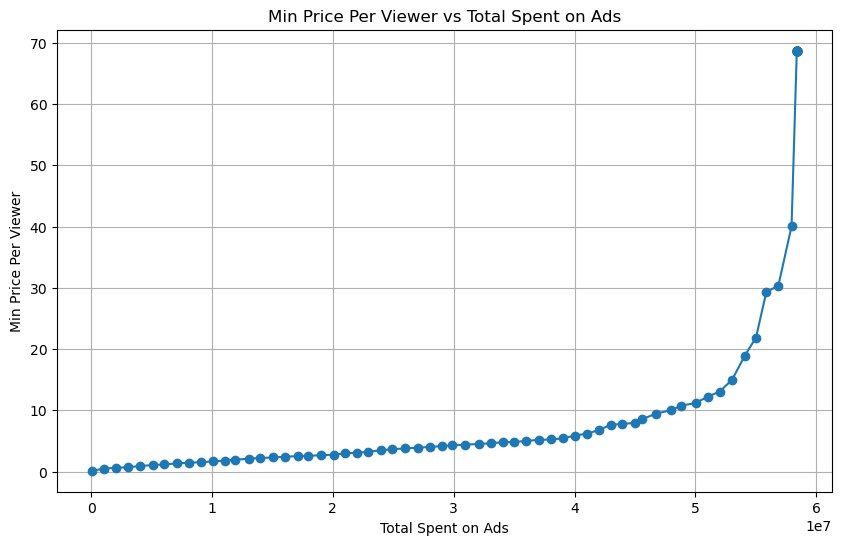

In [684]:
import matplotlib.pyplot as plt

# Initialize budget range up to 100,000,000
budgets = [int(x) for x in range(100000, 100000001, 1000000)]

# Track total spent and the corresponding min_price_x_viewer for each budget
total_spent_on_ads = []
min_price_per_viewer_values = []

# Iterate through budgets and calculate total spent and min price per viewer
for budget in budgets:
    selected_slots, remaining_budget = select_ad_slots(sorted_conversion_rates, budget)
    total_spent = budget - remaining_budget  # Total spent is the initial budget minus remaining budget
    if not selected_slots.empty:
        min_price_per_viewer = selected_slots['min_price_x_viewer'].iloc[-1]  # Get the last (highest) min_price_x_viewer
    else:
        min_price_per_viewer = 0  # Handle case when no slots are selected
    
    total_spent_on_ads.append(total_spent)
    min_price_per_viewer_values.append(min_price_per_viewer)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(total_spent_on_ads, min_price_per_viewer_values, marker='o')
plt.xlabel("Total Spent on Ads")
plt.ylabel("Min Price Per Viewer")
plt.title("Min Price Per Viewer vs Total Spent on Ads")
plt.grid(True)
plt.show()
